Необходимо оценить возраст человека по изображению. В качестве датасета используется IMDB-WIKI only faces. Задача решается как задача регрессии.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, CategoryEncoding,\
                                    Dropout, BatchNormalization, AveragePooling2D, GlobalMaxPool2D
#import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError
import tensorflow as tf

pd.set_option('display.max_rows', 30)

In [2]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
df = pd.DataFrame(columns=['link', 'age']) ### Создаем пустой Dataframe с колонками Link - ссылка на файл, Age - Возраст

for folder_name in tqdm(os.listdir ('wiki_crop')):
    for file_name in os.listdir('wiki_crop\\'+folder_name):
        #формируем ссылку на изображение
        link = 'wiki_crop\\' + folder_name + '\\' + file_name
        
        #### Распознавание лица с помощью каскадов Хаара
        img = cv2.imread(link)
        if img.shape[0]<96: ### Уберем совсем мелкие и неинформативные изображения
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 6) ## Выставим досточно жесткие условия.
        
        #### Если лицо обнаружено (сумма элементов массива больше 0), то добавляем строку в Dataframe
        if len(faces)>0:
            if len(faces)>1: ### Уберем изображения, на которых выявлено несколько лиц.
                continue
            #определяем возраст
            name = file_name[:-4] #убираем расширение файла из имени
            age_end = name.split('_')[2] # делаем сплит по нижнему подчеркиванию и выбираем последнюю дату
            age_start=str(name.split('_')[1]).split('-')[0] # делаем сплит, выбираем первую дату и далаем сплит по дефису, 
                                                            # выбираем год.
            age_fin = int(age_end)-int(age_start) #Вычисляем возраст
            
            if age_fin>100 or age_fin<0: # Если возраст больше 100 или меньше 0, то выкидываем из набора
                continue
            
            #формируем временный датафрейм
            data = pd.DataFrame({"link": [link],
                                 "age": [age_fin]})
            #Делаем конкатенацию с основным датафреймом.
            df = pd.concat([df,data])

df.to_csv('data_cleaned.csv') #Сохраним в файл полученный Dataframe на случай перезагрузки, чтобы не чистить второй раз )))

100%|██████████| 100/100 [06:05<00:00,  3.65s/it]


In [3]:
df = pd.read_csv('data_cleaned.csv')

In [4]:
df_croped = pd.DataFrame(columns=['link', 'age']) ### Создаем пустой Dataframe с колонками Link - ссылка на файл, Age - Возраст

for index in tqdm(range(len(df))): #
    link = df.iloc[index]['link']
    age = df.iloc[index]['age']
    f_name = df.iloc[index]['link'].split('\\')[-1]
    new_link = 'croped\\' + f_name
    
    img = cv2.imread(link)
    
    if img.shape[0]<150: #уберем совсем мелкие изображения, где распознать лицо затруднительно.
        continue
    
    if img.shape[-1]==3:
        img_new = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_new = img
    
    faces = face_cascade.detectMultiScale(img_new, 
                                          1.05, 
                                          2)
    
    if len(faces)>0: ### Выберем только то, где найдены лица.
        
        if len(faces)>1: ### Если выявлены множественные лица - пропуск
            continue
            
        x, y, w, h = faces[0]
        face_selected = img[y:y+h, x:x+h] ### Выделим лица
        cv2.imwrite(new_link,             ### Сохраним в файл с таким же именем, но в новую папку.
                    face_selected)
        
        data = pd.DataFrame({"link": [new_link],
                             "age": [age]})
        
        df_croped = pd.concat([df_croped,data])
        
df_croped.to_csv('data_croped.csv')

100%|██████████| 26635/26635 [11:05<00:00, 40.05it/s]


In [5]:
df = pd.read_csv ('data_croped.csv')

In [6]:
df.head()

,Unnamed: 0,link,age
0,0,croped\10049200_1891-09-16_1958.jpg,67
1,0,croped\10110600_1985-09-17_2012.jpg,27
2,0,croped\1013900_1917-10-15_1960.jpg,43
3,0,croped\10166400_1960-03-12_2008.jpg,48
4,0,croped\10525500_1916-02-14_1951.jpg,35


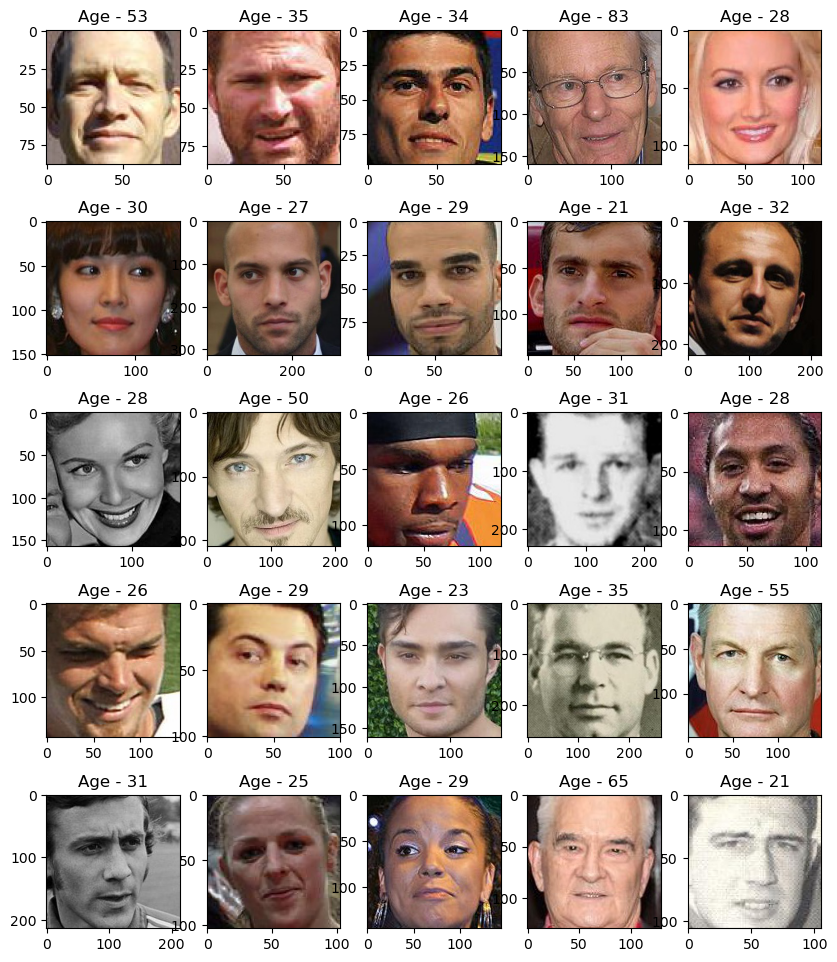

In [7]:
idx = np.random.randint (0,len(df),25)
plt.figure(figsize=(10,12))
for idx in enumerate(idx):
    plt.subplot (5,5,idx[0]+1)
    link = df.iloc[idx[1]]
    image = plt.imread(link[1])
    title = 'Age - ' + str(link[2])
    plt.title (title)
    plt.imshow(image, cmap='gray');

In [8]:
#разобьем датасет на тренировочную и тестовую выборки

train, test = train_test_split(df, random_state = 42, train_size=0.7)

In [19]:
#создадим генератор
train_data=ImageDataGenerator(rescale=1./255.,validation_split=0.3)
test_data=ImageDataGenerator(rescale=1./255.)

In [20]:
TARGET_SIZE = (224,224)

train_generator = train_data.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="link",
y_col="age",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

valid_generator = train_data.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="link",
y_col="age",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

test_generator = test_data.flow_from_dataframe(
dataframe=test,
directory="./",
x_col="link",
y_col="age",
batch_size=32,
seed=42,
shuffle=False,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

Found 8248 validated image filenames.
Found 3534 validated image filenames.
Found 5050 validated image filenames.


In [24]:
#### Создаем архитектуру модели
model_conv = Sequential()

model_conv.add (Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(112,112,3)))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))

model_conv.add (Conv2D(128, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))

model_conv.add (Conv2D(256, (3,3), padding='same', activation='relu'))

model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))

model_conv.add (Conv2D(512, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))

model_conv.add (Conv2D(512, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))

model_conv.add(GlobalMaxPool2D())

model_conv.add(Dense(1000, activation='relu'))

model_conv.add(Dense(1, activation='linear'))

model_conv.compile(optimizer=Adam(learning_rate=0.00005), loss='mse', metrics=['mae'])

#### Задаем колбэки
checkpoint_cb_conv = ModelCheckpoint("ConvModelFull.h5", 
                                     monitor = 'val_mae',
                                     save_best_only=True)

lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)

#### Обучаем модель
history2 = model_conv.fit(train_generator,
                          validation_data=valid_generator,
                          callbacks=[checkpoint_cb_conv,lr_scheduler],
                          epochs=10)

Epoch 1/10
258/258 [==============================] - 688s 3s/step - loss: 426.1639 - mae: 15.9812 - val_loss: 250.2793 - val_mae: 12.8664 - lr: 5.0000e-05
Epoch 2/10
258/258 [==============================] - 690s 3s/step - loss: 275.7663 - mae: 13.3150 - val_loss: 261.1256 - val_mae: 13.6263 - lr: 5.0000e-05
Epoch 3/10
258/258 [==============================] - 687s 3s/step - loss: 274.4626 - mae: 13.2350 - val_loss: 249.1485 - val_mae: 13.1605 - lr: 5.0000e-05
Epoch 4/10
258/258 [==============================] - 691s 3s/step - loss: 268.5332 - mae: 13.0911 - val_loss: 246.0247 - val_mae: 13.0610 - lr: 5.0000e-05
Epoch 5/10
258/258 [==============================] - 691s 3s/step - loss: 264.8892 - mae: 13.0267 - val_loss: 262.9768 - val_mae: 12.2719 - lr: 5.0000e-05
Epoch 6/10
258/258 [==============================] - 711s 3s/step - loss: 263.3228 - mae: 12.9389 - val_loss: 229.8732 - val_mae: 12.2170 - lr: 5.0000e-05
Epoch 7/10
258/258 [==============================] - 692s 3s/st

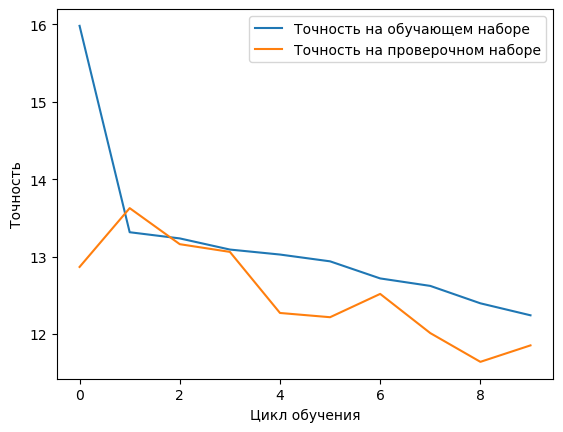

In [28]:
plt.plot(history2.history['mae'], label='Точность на обучающем наборе')
plt.plot(
    history2.history['val_mae'], label='Точность на проверочном наборе')
plt.xlabel('Цикл обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()
pass;